## Neural Network

* In this section, neural networks will be utilized to **predict** the **LogP** value. 

> For tabular data, feedforward neural networks, particularly Multilayer Perceptrons (MLPs), are commonly chosen. These networks consist of an input layer, one or more hidden layers, and an output layer. Tabular data often has complex relationships and patterns, and MLPs are versatile in capturing such nonlinearities. 

* Additionally, we will explore how the inclusion of **polynomial and rational difference features** can enhance the model's performance. One of the goals of this study is to compare how well different models (linear regression, random forest, neural networks) manage with reproducing those features.


* To mitigate overfitting in MLP models, **regularization techniques**, such as including **dropout layers**, **weight constraints**, and **early stopping**, will be employed.


* For models with a large number of features, we will utilize **Principal Component Analysis (PCA) to decrease dimensionality**, aiming to enhance the generalization performance of the models.


* At the end, a summary of the model's performance at different levels of complexity will be provided.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modules for data preprocessing and feature engineering
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression, mutual_info_regression

# modules for model selection and evaluation
from sklearn.model_selection import KFold, cross_validate, GridSearchCV#, cross_val_score  
from sklearn.metrics import mean_squared_error, r2_score

# modules for building the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modules for building neural networks and using Keras models with Scikit-learn functionality
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

# Import Principal Component Analysis module
from sklearn.decomposition import PCA

# saving sklearn models
import joblib

# import functions developed for evaluating metrics in this project
import performance_metrics as pm

### Dataset

To begin, we will import the train-validation and test sets. In the test set, 20% of the original dataset is kept for the final evaluation of the model's performance and for making comparisons between various models.

In [2]:
# import training-validation set and test set
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# separate the datasets into features and the target variables
X_train = df_train.drop('logp', axis=1)
y_train = df_train['logp']

X_test = df_test.drop('logp', axis=1)
y_test = df_test['logp']

In [4]:
print(f'The size of the \033[1mtrain set\033[0m is: \033[1m{len(X_train)}\033[0m and the size of the \033[1mtest set\033[0m is: \033[1m{len(X_test)}\033[0m')

The size of the train set is: 49094 and the size of the test set is: 12274


In [5]:
# list of original features
original_features = ['mwt', 'rings', 'heavy_atoms', 'hetero_atoms', 'fraction_sp3',
       'charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'rotatable_bonds1',
       'apolar_des1', 'polar_des1', 'RDtpsa', 'RDCfraction']

### 1. Baseline Neural Network Model 

To establish a **baseline for tracking differences** between the models' performance, particularly with the addition of engineered features, we'll begin with a basic model that utilizes only the original features and does not include any transformers.

Let's create a **function** which will provide a flexible way **to create a multi-layer perceptron (MLP) model** with different configurations for the number of layers, neurons, activation functions, optimizer, and learning rate. 

In [6]:
def create_mlp_model(input_dim=None, hidden_layer_sizes=[100], activation='relu', optimizer='adam', learning_rate=0.001):
    '''
    Creates a multi-layer perceptron (MLP) model with customizable architecture.

    Parameters:
    - input_dim: Number of input features. If None, input dimension is determined dynamically.
    - hidden_layer_sizes: List specifying the number of neurons in each hidden layer.
    - activation: Activation function for hidden layers.
    - optimizer: Optimizer for model training (supports 'adam' and 'sgd').
    - learning_rate: Learning rate for the chosen optimizer.

    Returns:
    - Compiled Keras model.
    '''
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layer_sizes[0], input_dim=input_dim, activation=activation))

    # Hidden layers
    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Choose the optimizer
    if optimizer.lower() == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer_instance)
    
    return model

Let's construct a pipeline that includes a data scaler (StandardScaler) and a KerasRegressor utilizing a multi-layer perceptron (MLP) model. The MLP model is defined by the `create_mlp_model` function.

In [7]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train[original_features].shape[1], epochs=10, batch_size=32, verbose=1))
])

Let's specify a set of parameters to explore when configuring the `create_mlp_model` function. Given the limited number of features (13), it could be beneficial to explore architectures with more than 2 hidden layers. Such architectures have the potential to learn intricate representations, effectively serving as a form of feature engineering (https://www.heatonresearch.com/2017/06/01/hidden-layers.html)

In [8]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes': [
        [128], [64], [32],  # Single-layer architectures
        [128, 64], [64, 32],  # Two-layer architectures
        [128, 64, 32], [64, 32, 16],  # Three-layer architectures
        [128, 64, 32, 16], [64, 32, 16, 8],  # Four-layer architectures
        [128, 64, 32, 16, 8], [64, 32, 16, 8, 4]],  # Fivee-layer architectures
    'nn__model__activation': ['relu','tanh'],
    'nn__model__learning_rate': [0.001, 0.0001],
    'nn__model__optimizer': ['adam','sgd']
}

The size of each fold used in cross-validation throughout this part of the study will be approximately 10 000 samples.

In [9]:
# Dividing the training-validation dataset into 5 folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

As previously, we will employ two **scoring** methods: **Mean Squared Error (MSE) and R-squared (R²)**, and the optimal model will be selected based on the MSE outcomes.

In [10]:
# Define a dictionary of scoring metrics for model evaluation
scoring = {
    'MSE': 'neg_mean_squared_error',
    'R-squared': 'r2'
}

Let's identify the optimal parameters. In this step, **models will be trained for only 10 epochs to fine-tune the hyperparameters and select the best architecture**. Utilizing 5-fold cross-validation provides standard deviations associated with metrics, enabling the **estimation of uncertainties of the mean scores**.

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_basic = grid_search.fit(X_train[original_features], y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_result, 'models/NN_basic_grid_results.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were determined using optimal parameters, including 'relu' activation, 'adam' optimizer, and a learning rate of 0.001: **[256], [512], [256, 128], [512, 256], [256, 128, 64], [512, 256, 128], [1024, 512, 256], [2048, 1024, 512], [256, 128, 64, 32], [512, 256, 128, 64], [1024, 512, 256, 128], [2048, 1024, 512, 256]**

In [11]:
grid_basic = joblib.load('models/NN_basic_grid_results_extension.joblib')

Let's examine the **outcomes of the optimization**.
The best parameters were found to be as follows:

In [12]:
# the best parameters
best_params = grid_basic.best_params_
best_params

{'nn__model__activation': 'relu',
 'nn__model__hidden_layer_sizes': [512, 256, 128],
 'nn__model__learning_rate': 0.001,
 'nn__model__optimizer': 'adam'}

In [13]:
# summary of the GridSearchCV
results = joblib.load('models/NN_basic_grid_results_extended.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8997 (0.0019)
Test set R2 score: 0.8860 (0.0026)

Training set MSE score: -0.1557 (0.0027)
Test set MSE score: -0.1769 (0.0028)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**. To enhance clarity in the visualization, we'll arrange the architectures based on an ascending order of the number of layers and nodes.

In [14]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

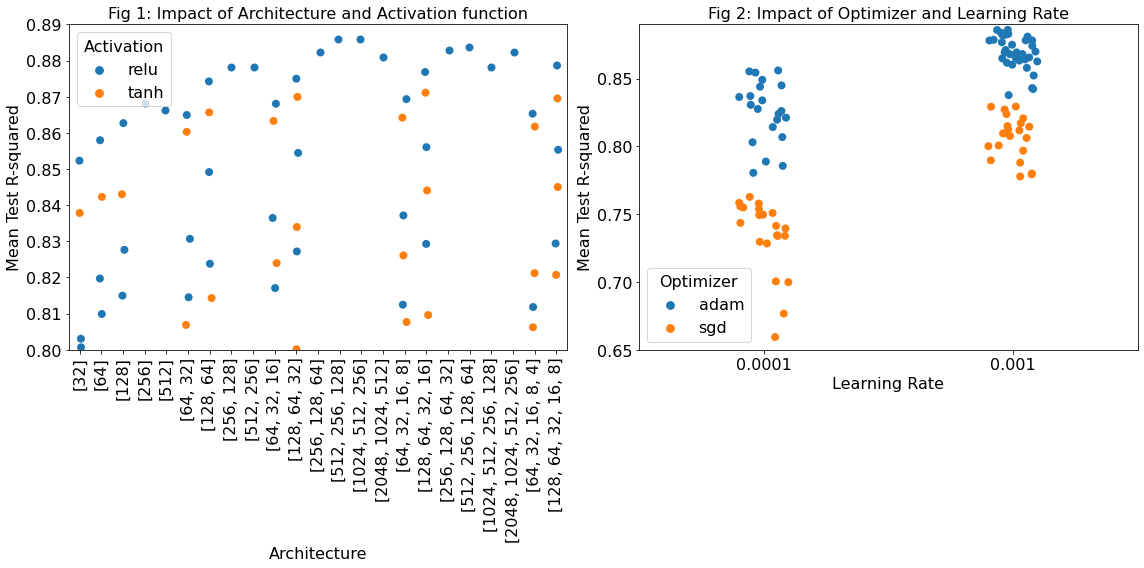

In [15]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 1: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 1: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.8, 0.89])

# fig 2: Impact of Optimizer and Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 2: Impact of Optimizer and Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.65, 0.89])

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

In Figure 1, a significant difference in performance is evident between models with one hidden layer and those with multiple layers. The network achieves optimal performance with **three hidden layers**, and the **widest layer consisting of 512 neurons**. Furthermore, optimal results are observed when utilizing the Rectified Linear Unit (**ReLU**) activation function. 

Fig 2 illustrates that the **Adam optimizer** outperforms Stochastic Gradient Descent (SGD). Among learning rates, the most favorable results were obtained with a **rate of 0.001**.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for additional epochs, employing an early stopping mechanism, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.

In [16]:
# Create the MLP model using the best parameters
model = create_mlp_model(
    input_dim=X_train[original_features].shape[1],
    activation=best_params['nn__model__activation'],
    hidden_layer_sizes=best_params['nn__model__hidden_layer_sizes'],
    learning_rate=best_params['nn__model__learning_rate'],
    optimizer=best_params['nn__model__optimizer']
)

In [17]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
# Scale the input data
X_train_basic = pipeline[:-1].fit_transform(X_train[original_features])
X_test_basic = pipeline[:-1].transform(X_test[original_features])

In [ ]:
# Fit the MLP model
history_basic = model.fit(X_train_basic, y_train, validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[early_stopping])

In [19]:
# save/load the information about the training process
#joblib.dump(history_basic, 'models/NN_history_basic.joblib')
history_basic = joblib.load('models/NN_history_basic.joblib')
#joblib.dump(model, 'models/NN_model_basic.joblib')
model = joblib.load('models/NN_model_basic.joblib')

Let's visualize the **progression of training and test set loss over epochs** during the training of the MLP model.

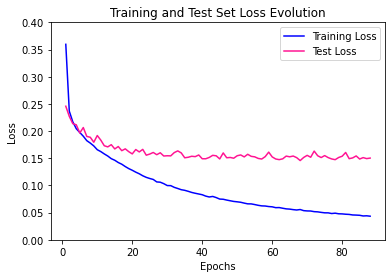

In [20]:
# Extract training and test set loss values from the training history
train_loss = history_basic.history['loss']
test_loss = history_basic.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.0, 0.4])
plt.legend()

plt.show()

Using Mean Squared Error (MSE) as our loss function, we observe that the model has not overfitted, however, it **stops improving** on the test set, suggesting further training may not be necessary.

Let's examine the **final scores for this model**.

In [21]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model.predict(X_train_basic).flatten())
y_test_pred = pd.Series(model.predict(X_test_basic).flatten())

384/384 [==============================] - 0s 924us/step


In [22]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train[original_features])

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9512)
Test set adjusted R2 score: 0.9014)

Training set MSE score: -0.0757)
Test set MSE score: -0.1571)


The metrics obtained just above for the unseen data, as well as those obtained during GridSearchCV a few lines earlier, provide us with a **baseline for the model's performance**.


To simplify the comparison of model performance at various stages of model development, let's consolidate all the metrics into a single dataframe.

In [23]:
# make a dataframe which stores the performance metrics
index = pd.MultiIndex.from_tuples([('Train', 'CV_R2'), ('Train', 'CV_R2_std'), ('Train', 'CV_MSE'), ('Train', 'CV_MSE_std'), ('Train', 'Adjusted R2'), ('Train', 'MSE'), ('Test', 'CV_R2'), ('Test', 'CV_R2_std'), ('Test', 'CV_MSE'), ('Test', 'CV_MSE_std'), ('Test', 'Adjusted R2'), ('Test', 'MSE')], names=['Set', 'Scoring'])
NN_scores = pd.DataFrame(index=index)

In [24]:
def add_scores(column_name):
    """
    the function adds performance metrics calculated before to a dataframe
    """
    NN_scores[column_name] = [pm.CV_train_R2, pm.CV_train_R2_std, pm.CV_train_MSE, pm.CV_train_MSE_std, pm.train_adjusted_R2, pm.train_MSE, pm.CV_test_R2, pm.CV_test_R2_std, pm.CV_test_MSE, pm.CV_test_MSE_std, pm.test_adjusted_R2, pm.test_MSE]

Now, let's integrate the scores of our basic model into the dataframe. We will utilize them later to make comparisons between various models.

In [25]:
add_scores('baseline')

As the final step, let's **visualize how well the model predicts** the values by plotting them alongside the actual values.

Visual representation of the model's fit to the **training-validation set**.

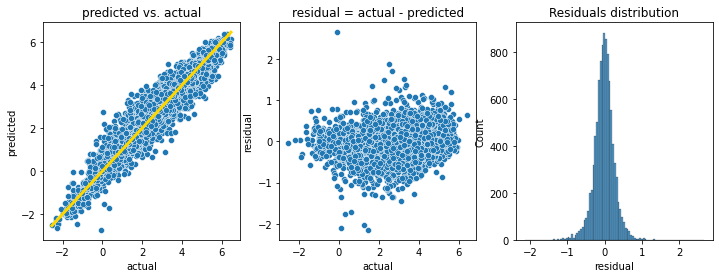

In [26]:
pm.visualize_fit(y_train, y_train_pred)

Visual representation of the model's fit to the **unseen test set**.

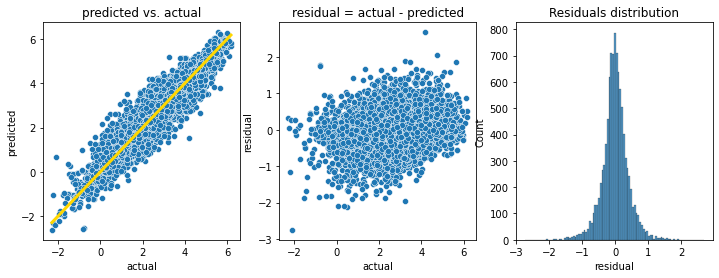

In [27]:
pm.visualize_fit(y_test, y_test_pred)

The model exhibits a strong fit to the training set and consistently performs well on the test set. Notably, the **residual versus actual value plots** for both training and test sets reveal minimal patterns, representing a significant improvement compared to the Linear Regression and Random Forest models.

### 2. Refined Neural Network Model 

To evaluate the **impact of feature engineering on various models** (Linear Regression, Random Forest, Neural Networks), let's assess how the **introduction of additional features, transformers, and scalers** influences the performance of the Multi-Layered Perceptron. To gain a clearer understanding of their impact on the model, we will introduce each type of feature one at a time.

### 2A. Polynomial Features

### _2A.1. Polynomial features_ ###

To prevent the need for generating polynomial features in each run of GridSearchCV let's create polynomial features of degree 3 derived from the original features (there is no risk of data leakage because PolynomialFeatures don't rely on any population parameters; they are calculated row-wise).

In [28]:
# Create a PolynomialFeatures object with a degree of 3
poly = PolynomialFeatures(degree=3, include_bias=False)

# Apply the polynomial transformation to the training and test sets
X_train_poly = pd.DataFrame(poly.fit_transform(X_train[original_features]))
X_test_poly = pd.DataFrame(poly.transform(X_test[original_features]))

Let's construct a pipeline that incorporates both a scaler and an MLP model.

In [29]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train_poly.shape[1], epochs=10, batch_size=32, verbose=1))
])

The model will be optimized using the following parameters.

In [30]:
param_grid = {
    'nn__model__hidden_layer_sizes': [
        [256], [128], [64], [32],  # Single-layer architectures
        [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [256, 128, 64], [128, 64, 32]  # Three-layer architectures
    ],
    'nn__model__activation': ['relu', 'tanh'],
    'nn__model__learning_rate': [0.01, 0.001, 0.0001],
    'nn__model__optimizer': ['adam', 'sgd']
}

Let's identify the optimal parameters. In this step, **models will be trained for only 10 epochs to fine-tune the hyperparameters and select the best architecture**. Utilizing 5-fold cross-validation provides standard deviations associated with metrics, enabling the **estimation of uncertainties** in the mean scores.

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_poly = grid_search.fit(X_train_poly, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_poly, 'models/NN_poly_grid_results_extended.joblib')

In [31]:
# load the results
grid_poly = joblib.load('models/NN_poly_grid_results_extension2.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were evaluates using optimal parameters, including 'relu' and 'tanh' activation, 'adam' optimizer, and a learning rate of 0.0001: **[512], [512, 256], [512, 256, 128], [1024, 512, 256], [2048, 1024, 512], [4096, 2048, 1024], [256, 128, 64, 32], [512, 256, 128, 64], [1024, 512, 256, 128], [2048, 1024, 512, 256], [4096, 2048, 1024, 512], [4096, 2048, 1024, 512, 256], [2048, 1024, 512, 256, 128]**

Let's examine the **outcomes of the optimization**.

In [32]:
# load the results
results = joblib.load('models/NN_poly_grid_results_all.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9124 (0.0043)
Test set R2 score: 0.8870 (0.0051)

Training set MSE score: -0.1360 (0.0066)
Test set MSE score: -0.1753 (0.0075)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**.

In [33]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

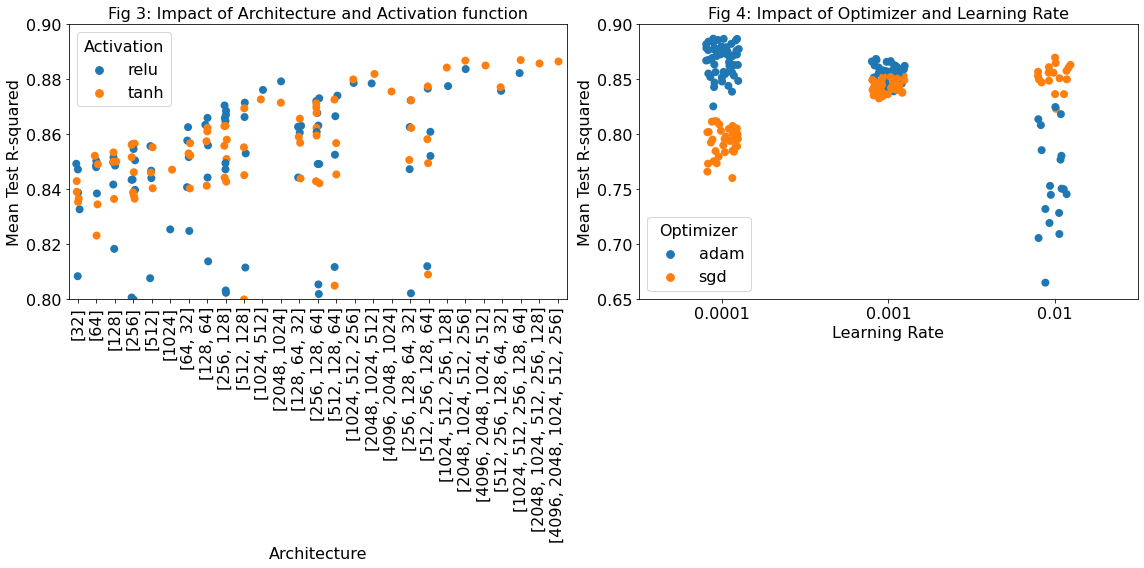

In [34]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 3: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 3: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.8, 0.9]) 

# fig 4: Impact of Optimizer and Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 4: Impact of Optimizer and Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.65, 0.90])

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

In Figure 3, the most notable distinction is between models with a single hidden layer and those with multiple layers. **Beyond four hidden layers, additional layers do not yield significant performance improvement**. The optimal architecture was identified as having **2048/1024/512/256 neurons**. Furthermore, it is evident that **for more complex architectures, the 'tanh' activation function outperforms the Rectified Linear Unit (ReLU)**.

Fig 4 illustrates that the **Adam optimizer** outperforms Stochastic Gradient Descent (SGD). Among learning rates, the most favorable results were obtained with a **rate of 0.0001**.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for additional epochs, employing an early stopping mechanism, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.

In [35]:
# MLP model with best parameters
model = create_mlp_model(
    input_dim= X_train_poly.shape[1],
    activation= 'tanh',
    hidden_layer_sizes= [2048, 1024, 512, 256],
    learning_rate= 0.0001,
    optimizer= 'adam'
)

In [36]:
# Scale the data
X_train_poly = pd.DataFrame(pipeline.named_steps['scaler'].fit_transform(X_train_poly))
X_test_poly = pd.DataFrame(pipeline.named_steps['scaler'].transform(X_test_poly))

In [ ]:
# Fit the MLP model
history_poly = model.fit(X_train_poly, y_train, validation_split=0.2, epochs=150, batch_size=32, verbose=0, callbacks=[early_stopping])

In [37]:
# save/load the information about the training process
#joblib.dump(history_poly, 'models/NN_history_poly.joblib')
history_poly = joblib.load('models/NN_history_poly.joblib')
#joblib.dump(model, 'models/NN_model_poly.joblib')
model = joblib.load('models/NN_model_poly.joblib')

Let's **visualize the progression of training and test set loss** over epochs during the training of the MLP model.

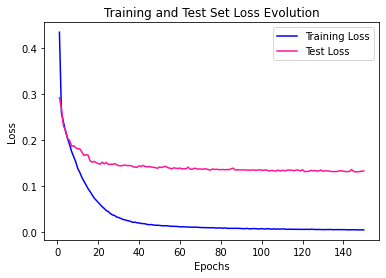

In [38]:
# Extract training and test set loss values from the training history
train_loss = history_poly.history['loss']
test_loss = history_poly.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0.2, 100000])
plt.legend()

plt.show()

The model has reached a stage where the test loss no longer improves. Training it for more epochs might lead to overfitting. The noticeable difference between the Training and Test Loss curves indicates that the model learned patterns specific to the training data, but these patterns do not generalize well to improve performance on the test set.

Before proceeding, let's incorporate the scores into the comparison.

In [39]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model.predict(X_train_poly).flatten())
y_test_pred = pd.Series(model.predict(X_test_poly).flatten())

384/384 [==============================] - 2s 5ms/step


Now, we can present the **metrics** for both the **complete training-validation set and the unseen test set**.

In [40]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train_poly)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9803)
Test set adjusted R2 score: 0.9121)

Training set MSE score: -0.0303)
Test set MSE score: -0.1339)


Now, let's integrate the scores of the model with additional, polynomial features into the dataframe and **visualize the results**.

In [41]:
add_scores('polynomial')

In [42]:
NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Test') & NN_scores.index.get_level_values(1).isin(['CV_R2', 'CV_R2_std', 'Adjusted R2'])]

baseline  polynomial
Set  Scoring                          
Test CV_R2        0.885952    0.887008
     CV_R2_std    0.002607    0.005090
     Adjusted R2  0.901372    0.912053

Text(0, 0.5, 'Test R-squared')

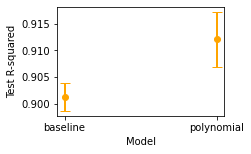

In [43]:
# compare baseline model with the model with polynomial features added
columns = ['baseline', 'polynomial']

# select test set R2 scores with std of the test set
df = NN_scores[columns].loc[(NN_scores.index.get_level_values(0) == 'Test') & (NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xlabel('Model')
plt.ylabel('Test R-squared')

Above, we observe a **statistically significant improvement in the model's performance after the addition of polynomial features**.

### _2A.2 Polynomial features + Regularization_ ###

It is commonly recommended to contemplate incorporating regularization unless dealing with a very large dataset. The optimal model often involves a larger structure that has been suitably regularized.

Let's investigate whether **adopting a more complex architecture, along with incorporating regularization techniques** such as dropout and introducing a weight constraint, can result in improved outcomes.

To implement these changes, we will define a new function to create an MLP model that integrates the specified regularization techniques. The model includes **Dropout Layers** and employs **MaxNorm weight constraints**.

In [44]:
# Create MLP model with Dropout layers and MaxNorm weight constraints
def create_regularized_mlp_model(input_dim=None, hidden_layer_sizes=[100], activation='relu', optimizer='adam', learning_rate=0.001, dropout_rate=0.0, weight_constraint=None):
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layer_sizes[0], input_dim=input_dim, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))

    # Hidden layers with dropout
    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Choose the optimizer
    optimizer_instance = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer_instance)

    return model

Let's construct a pipeline that incorporates both a scaler and the `regularized MLP model`.

In [45]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_regularized_mlp_model, input_dim=X_train_poly.shape[1], epochs=10, batch_size=32, verbose=1))
])

To assess the impact of dropout and weight constraints, we selected an architecture with double the number of neurons compared to the best architecture. The model will be fine-tuned without dropout or with a 20% dropout rate, and without a weight constraint or with a MaxNorm weight constraint set to 3.

In [46]:
param_grid = {
    'nn__model__hidden_layer_sizes': [[4096, 2048, 1024, 512, 256]],
    'nn__model__activation': ['tanh'],
    'nn__model__learning_rate': [0.0001],
    'nn__model__dropout_rate': [0.0, 0.2],
    'nn__model__weight_constraint': [None, 3],
}

Let's identify the optimal parameters. In this step, **each model will be trained for only 10 epochs to fine-tune the hyperparameters and select the best architecture**. Utilizing 5-fold cross-validation provides standard deviations associated with metrics, enabling the **estimation of uncertainties** in the mean scores.

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=3)
grid_poly_reg = grid_search.fit(X_train_poly, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_poly_reg, 'models/NN_poly_reg_grid_results.joblib')

In [47]:
# load the results
grid_poly_reg = joblib.load('models/NN_poly_reg_grid_results.joblib')

Let's examine the **outcomes of the optimization**.

In [48]:
# the best parameters
best_params = grid_poly_reg.best_params_
best_params

{'nn__model__activation': 'tanh',
 'nn__model__dropout_rate': 0.0,
 'nn__model__hidden_layer_sizes': [4096, 2048, 1024, 512, 256],
 'nn__model__learning_rate': 0.0001,
 'nn__model__weight_constraint': 3}

In [49]:
# summary of the GridSearchCV
results = pd.DataFrame(grid_poly_reg.cv_results_)

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9259 (0.0026)
Test set R2 score: 0.8804 (0.0024)

Training set MSE score: -0.1149 (0.0040)
Test set MSE score: -0.1855 (0.0039)


To gain a deeper insight into how parameter choices impact the performance of the model, let's **visualize the performance across various combinations of parameters**.

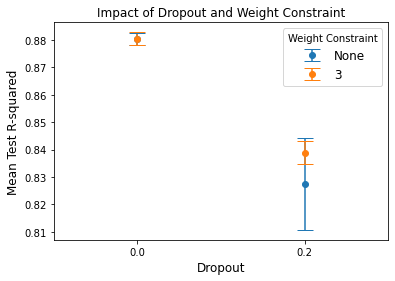

In [50]:
# Filter the results based on the Weight Constraint
results_weight_none = results[results['param_nn__model__weight_constraint'].isna()]
results_weight_3 = results[results['param_nn__model__weight_constraint'] == 3]

plt.errorbar(x=results_weight_none['param_nn__model__dropout_rate'], y=results_weight_none['mean_test_R-squared'], yerr=results_weight_none['std_test_R-squared'], marker='o', linestyle='', capsize=8)
plt.errorbar(x=results_weight_3['param_nn__model__dropout_rate'], y=results_weight_3['mean_test_R-squared'], yerr=results_weight_3['std_test_R-squared'], marker='o', linestyle='', capsize=8)

plt.title('Impact of Dropout and Weight Constraint', fontsize=12)
plt.xlabel('Dropout', fontsize=12)
plt.ylabel('Mean Test R-squared', fontsize=12)
plt.xlim([-0.1, 0.3]) 
plt.xticks([0.0, 0.2])  # Set x-axis ticks for specific dropout rates
plt.legend(['None', '3'], title='Weight Constraint', fontsize=12)

Above, it is evident that incorporating dropout leads to a noteworthy decrease in the model's performance. As for the weight constraint, although a slightly improved value was achieved with a MaxNorm weight constraint set to 3, this difference lacks statistical significance.

Given the observed difference is not statistically significant and given the substantially increased training time associated with MLP models featuring twice as many neurons, I opt not to transition to a regularized model with a more intricate architecture.

### _2A.3 Polynomial features + PCA_ ###

Considering the **substantial increase in the number of features following the addition of polynomial features**, it is worthwhile to assess the impact of **dimensionality reduction** on the model's performance.

The dataset with polynomial features has already been standardized, and it encompasses the following count of features:

In [51]:
X_train_poly.shape[1]

559

Let's fit the model and identify the number of components that contribute to **99% of the explained variance**.

In [52]:
# Initialize PCA 
pca = PCA()

# Fit and transform the data
X_train_poly_pca = pca.fit_transform(X_train_poly)

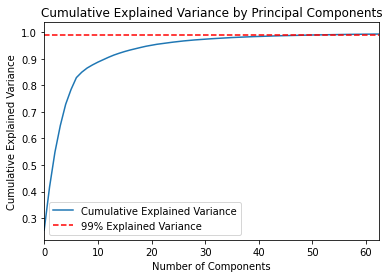

In [53]:
# Compute the explained variance ratio and cumulative explained variance
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = explained_var_ratio.cumsum()

# Find the number of principal components that explain at least 99% of the variance
n_components = np.argmax(cumulative_var_ratio >= 0.99) + 1

# Plot cumulative explained variance
plt.plot(cumulative_var_ratio, label='Cumulative Explained Variance')
plt.axhline(y=0.99, color='red', linestyle='--', label='99% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim([0, 1.2*n_components]) 
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.show()

To capture **99% of the variance**, we **require the following number of components**:

In [54]:
n_components

52

Let's initialize PCA with the number of components determined above and fit the model to **obtain datasets with a reduced number of features**.

In [ ]:
# Initialize PCA with the the number of features
pca = PCA(n_components)

# Fit and transform the data
X_train_poly_pca = pd.DataFrame(pca.fit_transform(X_train_poly))
X_test_poly_pca = pd.DataFrame(pca.transform(X_test_poly))

Now that we have a dataset with a reduced number of components, let's construct a pipeline, define a parameters grid, and optimize the model.

In [57]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train_poly_pca.shape[1], epochs=10, batch_size=32, verbose=1))
])

In [58]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes':[
        [1024], [512], [256], [128], [64], [32], # Single-layer architectures
        [1024, 512], [512, 256], [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [1024, 512, 256], [512, 256, 128], [256, 128, 64], [128, 64, 32],  # Three-layer architectures
        [1024, 512, 256, 128], [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16],  # Four-layer architectures
        [1024, 512, 256, 128, 64], [512, 256, 128, 64, 32], [256, 128, 64, 32, 16]],  # Fivee-layer architectures
    'nn__model__activation': ['relu', 'tanh'],
    'nn__model__learning_rate': [0.01, 0.001, 0.0001],
    'nn__model__optimizer': ['adam', 'sgd']
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_poly_pca = grid_search.fit(X_train_poly_pca, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_poly_pca, 'models/NN_poly_pca_grid_results.joblib')

In [61]:
# load the results
grid_poly_pca = joblib.load('models/NN_poly_pca_grid_results.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were evaluated using optimal parameters, including 'relu' and 'tanh' activation, 'adam' optimizer, and a learning rates of 0.001, 0.0001: **[2048, 1024, 512], [2048, 1024, 512, 256], [2048, 1024, 512, 256, 128]**

In [62]:
# load the GridSearchCV results
grid_poly_pca_extension = joblib.load('models/NN_poly_pca_grid_results_extension.joblib')

Let's examine the **outcomes of the optimization**.

In [63]:
# the best parameters
best_params_new = grid_poly_pca_extension.best_params_
best_params_new

{'nn__model__activation': 'relu',
 'nn__model__hidden_layer_sizes': [2048, 1024, 512],
 'nn__model__learning_rate': 0.0001,
 'nn__model__optimizer': 'adam'}

In [64]:
# summary of the GridSearchCV
results = joblib.load('models/NN_poly_pca_grid_results_extended.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9340 (0.0010)
Test set R2 score: 0.8949 (0.0028)

Training set MSE score: -0.1024 (0.0015)
Test set MSE score: -0.1631 (0.0032)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**.

In [65]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

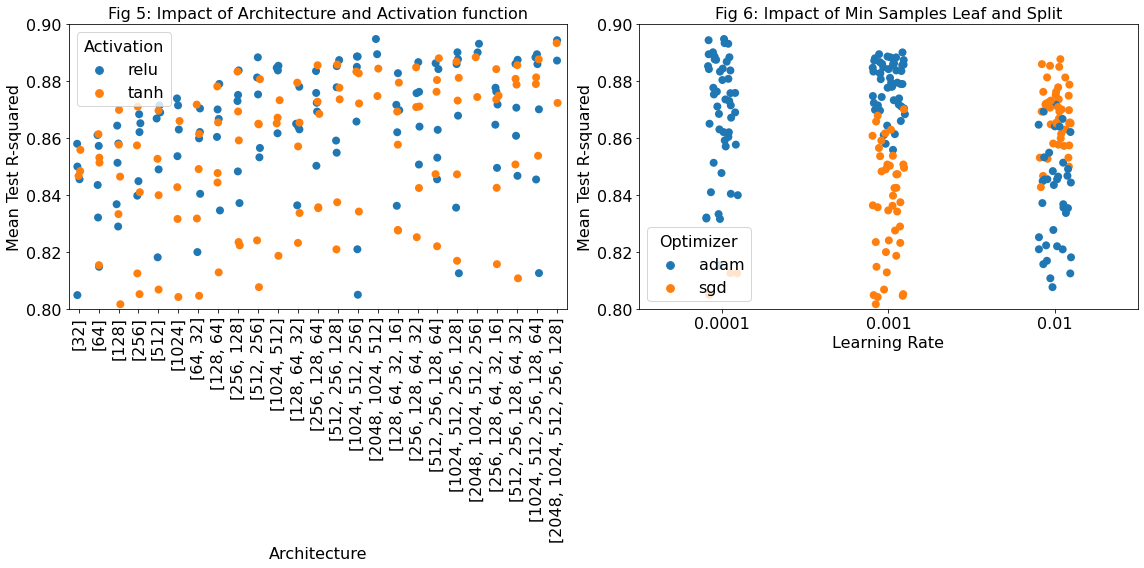

In [66]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 5: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 5: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.8, 0.9])

# fig 6: Impact of Optimizer and Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 6: Impact of Min Samples Leaf and Split', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.8, 0.9])

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

Similarly to the baseline model, which also had a smaller number of features, a **more compact architecture** is favored here as well, with **three layers** proving sufficient for optimal results. In this reduced architecture, the **'relu'** activation function yields superior performance.

Once again, the **'adam'** optimizer with a **learning rate of 0.0001** demonstrated the best outcomes.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for **additional epochs, employing an early stopping mechanism**, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.

In [67]:
# MLP model with best parameters
model = create_mlp_model(
    input_dim= X_train_poly_pca.shape[1],
    activation= 'relu',
    hidden_layer_sizes= [2048, 1024, 512],
    learning_rate= 0.0001,
    optimizer= 'adam'
)

In [68]:
# Scale the input data
X_train_poly_pca = pd.DataFrame(pipeline[:-1].fit_transform(X_train_poly_pca))
X_test_poly_pca = pd.DataFrame(pipeline[:-1].transform(X_test_poly_pca))

In [ ]:
# Fit the MLP model
history_poly_pca = model.fit(X_train_poly_pca, y_train, validation_split=0.2, epochs=150, batch_size=32, verbose=0, callbacks=[early_stopping])

In [69]:
# save/load the information about the training process
#joblib.dump(history_poly_pca, 'models/NN_history_poly_pca.joblib')
history_poly_pca = joblib.load('models/NN_history_poly_pca.joblib')
#joblib.dump(model, 'models/NN_model_poly_pca.joblib')
model = joblib.load('models/NN_model_poly_pca.joblib')

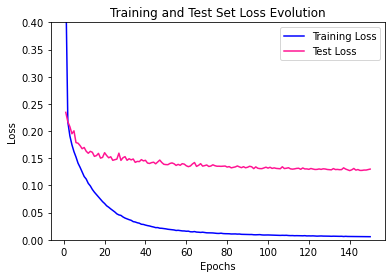

In [70]:
# Extract training and test set loss values from the training history
train_loss = history_poly_pca.history['loss']
test_loss = history_poly_pca.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.0, 0.4])
plt.legend()

plt.show()

In [71]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model.predict(X_train_poly_pca).flatten())
y_test_pred = pd.Series(model.predict(X_test_poly_pca).flatten())

384/384 [==============================] - 1s 3ms/step


Now, we can present the **metrics** for both the **complete training-validation set and the unseen test set**.

In [72]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train_poly_pca)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9432)
Test set adjusted R2 score: 0.8937)

Training set MSE score: -0.0880)
Test set MSE score: -0.1688)


Now, let's **incorporate the scores** of the model with PCA-reduced polynomial features into the dataframe and **visualize the results**.

In [73]:
add_scores('polynomial + PCA')

In [74]:
NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Test') & NN_scores.index.get_level_values(1).isin(['CV_R2', 'CV_R2_std', 'Adjusted R2'])]

baseline  polynomial  polynomial + PCA
Set  Scoring                                            
Test CV_R2        0.885952    0.887008          0.894873
     CV_R2_std    0.002607    0.005090          0.002762
     Adjusted R2  0.901372    0.912053          0.893718

Text(0, 0.5, 'Test R-squared')

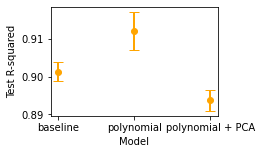

In [75]:
# compare the existing models
columns = ['baseline', 'polynomial', 'polynomial + PCA']

# select R2 scores with std of the test set
df = NN_scores[columns].loc[(NN_scores.index.get_level_values(0) == 'Test') & (NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xlabel('Model')
plt.ylabel('Test R-squared')

Above, it's evident that there is a **statistically significant difference in performance** between the baseline model and the model **after incorporating polynomial features**. Additionally, **dimensionality reduction** with PCA has notably **enhanced the model's performance**.

After careful analysis of this subchapter in which polynomial features were incorporated in the model, I've decided to **use PCA when adding more features**. This choice is informed by the **superior outcomes observed with PCA compared to the regularization techniques applied to the MLP model**, such as dropout layers and weight constraints, which failed to enhance the model's performance.

### 2B. Rational difference features ###

### _2B.1 Rational difference features_ ###

For now, let's set aside the polynomial features and focus solely on incorporating the features referred to as _rational differences_.  The motivation behind engineering features of this nature is rooted in the common observation that **models often struggle to synthesize expressions of this type effectively** <font color='gray'>_(J. Heaton, "An empirical analysis of feature engineering for predictive modeling," SoutheastCon 2016, Norfolk, VA, USA, 2016, pp. 1-6, doi: 10.1109/SECON.2016.7506650)_</font>.

Rational differences refer to equations written in this form: $\frac{a-b}{c-d}$. However, in this study, equations in this form were tested to prevent the generation of an excessive number of features:

$$\frac{a-b}{c}$$

Let's assess the impact of including these features on the performance of the linear model.

In [76]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train.shape[1], epochs=10, batch_size=32, verbose=1))
])

Previously, the 'adam' optimizer demonstrated superior performance, so to reduce training time, we will employ it directly.

In [77]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes': [
        [512], [256], [128], [64],  # Single-layer architectures
        [512, 256], [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [512, 256, 128], [256, 128, 64], [128, 64, 32],  # Three-layer architectures
        [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16],  # Four-layer architectures
        [512, 256, 128, 64, 32], [256, 128, 64, 32, 16]],  # Fivee-layer architectures
    'nn__model__activation': ['relu','tanh'],
    'nn__model__learning_rate': [0.001, 0.0001],
    'nn__model__optimizer': ['adam']
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_diff = grid_search.fit(X_train, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_diff, 'models/NN_diff_grid_result.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were determined using optimal parameters, including 'relu' and 'tanh' activations, 'adam' optimizer, and a learning rate of 0.0001: **[1024], [1024, 512], [1024, 512, 256], [2048, 1024, 512], [1024, 512, 256, 128], [2048, 1024, 512, 256], [4096, 2048, 1024, 512], [1024, 512, 256, 128, 64], [2048, 1024, 512, 256, 128], [4096, 2048, 1024, 512, 256]**

In [78]:
grid_diff = joblib.load('models/NN_diff_grid_result_extension2.joblib')

Let's examine the **outcomes of the optimization**. The best parameters were found to be as follows:

In [79]:
# the best parameters
best_params = grid_diff.best_params_
best_params

{'nn__model__activation': 'tanh',
 'nn__model__hidden_layer_sizes': [4096, 2048, 1024, 512, 256],
 'nn__model__learning_rate': 0.0001,
 'nn__model__optimizer': 'adam'}

In [80]:
# summary of the GridSearchCV
results = joblib.load('models/NN_diff_grid_results_all.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9187 (0.0035)
Test set R2 score: 0.8873 (0.0038)

Training set MSE score: -0.1262 (0.0056)
Test set MSE score: -0.1748 (0.0047)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**. To enhance clarity in the visualization, we'll arrange the architectures based on an ascending order of the number of layers and nodes.

In [81]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

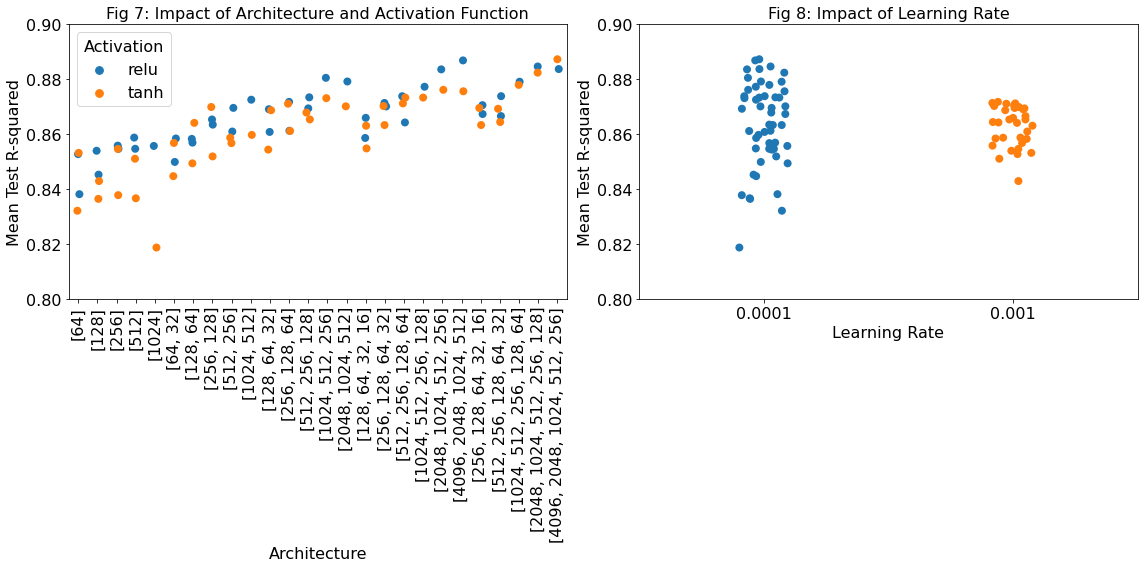

In [82]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 7: Impact of Architecture and Activation Function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 7: Impact of Architecture and Activation Function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.8, 0.9]) 

# fig 8: Impact of Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', ax=ax2, size=8)
ax2.set_title('Fig 8: Impact of Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.8, 0.9])

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

The optimal outcomes were achieved with the most intricate architecture, featuring 5 layers and a maximum layer width of 4096 neurons. However, as we observe a plateau, we refrain from adding more neurons. The best results were attained using 'tanh' activation, 'adam' optimizer, and a learning rate of 0.0001.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for additional epochs, employing an **early stopping** mechanism, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.


In [83]:
# MLP model with best parameters
model = create_mlp_model(
    input_dim=X_train.shape[1],
    activation=best_params['nn__model__activation'],
    hidden_layer_sizes=best_params['nn__model__hidden_layer_sizes'],
    learning_rate=best_params['nn__model__learning_rate'],
    optimizer=best_params['nn__model__optimizer']
)

In [84]:
# Scale the input data
X_train_diff = pd.DataFrame(pipeline[:-1].fit_transform(X_train))
X_test_diff = pd.DataFrame(pipeline[:-1].transform(X_test))

In [ ]:
# Fit the MLP model
history_diff = model.fit(X_train_diff, y_train, validation_split=0.2, epochs=600, batch_size=32, verbose=0, callbacks=[early_stopping])

In [87]:
# save/load the information about the training process
#joblib.dump(history_diff, 'models/NN_history_diff.joblib')
history_diff = joblib.load('models/NN_history_diff.joblib')
#joblib.dump(model, 'models/NN_model_diff.joblib')
model = joblib.load('models/NN_model_diff.joblib')

Let's **visualize the progression of training and test set loss** over epochs during the training of the MLP model.

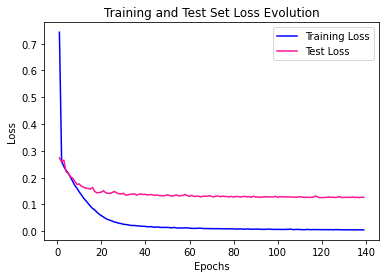

In [88]:
# Extract training and test set loss values from the training history
train_loss = history_diff.history['loss']
test_loss = history_diff.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0.2, 100000])
plt.legend()

plt.show()

In [89]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model.predict(X_train_diff).flatten())
y_test_pred = pd.Series(model.predict(X_test_diff).flatten())

384/384 [==============================] - 3s 8ms/step


The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [90]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9812)
Test set adjusted R2 score: 0.9168)

Training set MSE score: -0.0292)
Test set MSE score: -0.1311)


Let's include these values for future comparison with the earlier models. **We'll assess and compare them once we have the performance of the model with PCA applied**.

In [91]:
add_scores('rational_diff')

### _2B.2 Rational difference features + PCA_ ###

The dataset with polynomial features has already **been standardized**, and it encompasses the following **count of features**:

In [92]:
X_train_diff.shape[1]

149

Let's fit the model and **identify the number of components that contribute to 99% of the explained variance**.

In [93]:
# Initialize PCA with the the number of features
pca = PCA()

# Fit and transform the data
X_train_diff_pca = pca.fit_transform(X_train_diff)

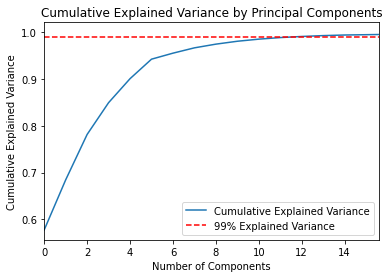

In [94]:
# Compute the explained variance ratio and cumulative explained variance
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = explained_var_ratio.cumsum()

# Find the number of principal components that explain at least 99% of the variance
n_components = np.argmax(cumulative_var_ratio >= 0.99) + 1

# Plot cumulative explained variance
plt.plot(cumulative_var_ratio, label='Cumulative Explained Variance')
plt.axhline(y=0.99, color='red', linestyle='--', label='99% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim([0, 1.2*n_components]) 
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.show()

To capture **99% of the variance**, we **require the following number of components**:

In [95]:
n_components

13

Let's initialize PCA with the number of components determined above and fit the model to **obtain datasets with a reduced number of features**.

In [96]:
# Initialize PCA with the the number of features
pca = PCA(n_components)

# Fit and transform the data
X_train_diff_pca = pd.DataFrame(pca.fit_transform(X_train_diff))
X_test_diff_pca = pd.DataFrame(pca.transform(X_test_diff))

Now that we have a dataset with a reduced number of components, let's construct a pipeline, define a parameters grid, and optimize the model.

In [97]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train_diff_pca.shape[1], epochs=10, batch_size=32, verbose=1))
])

In [98]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes':[
        [1024], [512], [256], [128], [64], [32], # Single-layer architectures
        [1024, 512], [512, 256], [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [1024, 512, 256], [512, 256, 128], [256, 128, 64], [128, 64, 32],  # Three-layer architectures
        [1024, 512, 256, 128], [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16],  # Four-layer architectures
        [1024, 512, 256, 128, 64], [512, 256, 128, 64, 32], [256, 128, 64, 32, 16]],  # Fivee-layer architectures
    'nn__model__activation': ['relu', 'tanh'],
    'nn__model__learning_rate': [0.01, 0.001, 0.0001],
    'nn__model__optimizer': ['adam', 'sgd']
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_diff_pca = grid_search.fit(X_train_diff_pca, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_diff_pca, 'models/NN_diff_pca_grid_results.joblib')

In [99]:
# load the results
grid_diff_pca = joblib.load('models/NN_diff_pca_grid_results.joblib')

Let's examine the **outcomes of the optimization**.

In [100]:
# the best parameters
best_params = grid_diff_pca.best_params_
best_params

{'nn__model__activation': 'relu',
 'nn__model__hidden_layer_sizes': [1024, 512, 256, 128, 64],
 'nn__model__learning_rate': 0.0001,
 'nn__model__optimizer': 'adam'}

In [101]:
# summary of the GridSearchCV
results = pd.DataFrame(grid_diff_pca.cv_results_)

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9095 (0.0047)
Test set R2 score: 0.8902 (0.0032)

Training set MSE score: -0.1405 (0.0072)
Test set MSE score: -0.1704 (0.0039)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**.

In [102]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

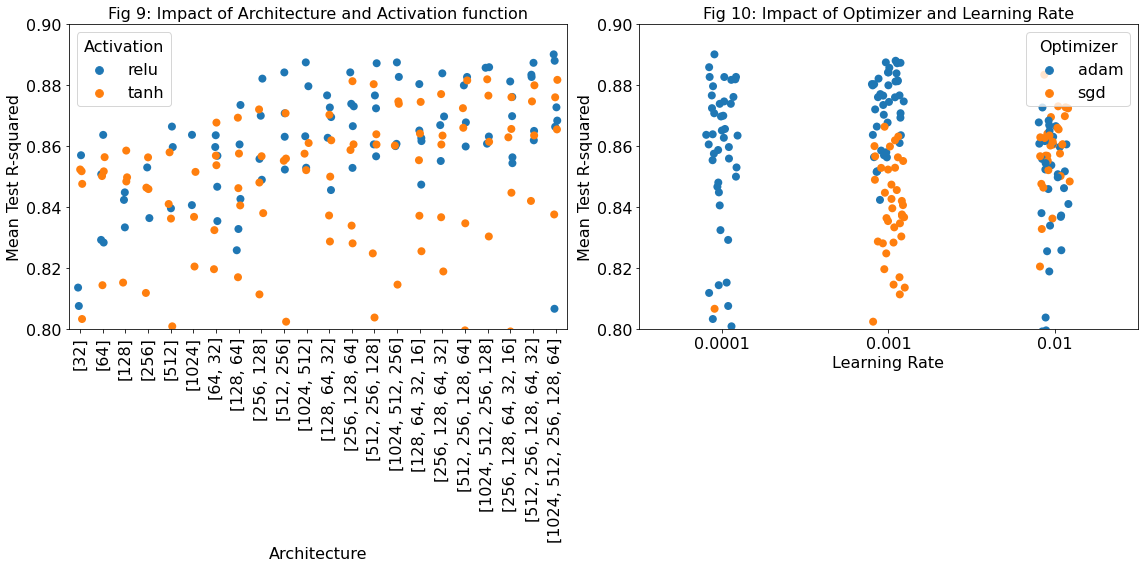

In [103]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 9: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 9: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.8, 0.9])

# fig 10: Impact of Optimizer and Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 10: Impact of Optimizer and Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.8, 0.9])

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

The distinction between the performance of the three-layer, four-layer and five-layer architectures is relatively modest, suggesting that **additional layers may not yield substantial improvements**. This pattern aligns with our observations from the model before regularization, where the most significant variance occurred between models with one, two and three layers. Following a thorough examination of the above plot, the selected architecture is **[1024, 512, 256, 128, 64]**.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for additional epochs, employing an **early stopping** mechanism, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.


In [104]:
# MLP model with best parameters
model_diff_pca2 = create_mlp_model(
    input_dim=X_train_diff_pca.shape[1],
    activation='relu',
    hidden_layer_sizes=[1024, 512, 256, 128, 64],
    learning_rate=0.0001,
    optimizer='adam'
)

In [105]:
# Scale the input data
X_train_diff_pca = pd.DataFrame(pipeline[:-1].fit_transform(X_train_diff_pca))
X_test_diff_pca = pd.DataFrame(pipeline[:-1].transform(X_test_diff_pca))

In [ ]:
history_diff_pca2 = model_diff_pca2.fit(X_train_diff_pca, y_train, validation_split=0.2, epochs=600, batch_size=32, verbose=0, callbacks=[early_stopping])

In [106]:
# save/load the information about the training process
#joblib.dump(history_diff_pca2, 'models/NN_history_diff_pca2.joblib')
history_diff_pca2 = joblib.load('models/NN_history_diff_pca2.joblib')
#joblib.dump(model_diff_pca2, 'models/NN_model_diff_pca2.joblib')
model_diff_pca2 = joblib.load('models/NN_model_diff_pca2.joblib')

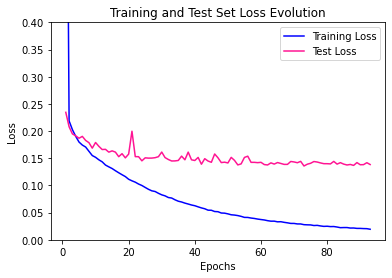

In [107]:
# Extract training and test set loss values from the training history
train_loss = history_diff_pca2.history['loss']
test_loss = history_diff_pca2.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.0, 0.4])
plt.legend()

plt.show()

In [108]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model_diff_pca2.predict(X_train_diff_pca).flatten())
y_test_pred = pd.Series(model_diff_pca2.predict(X_test_diff_pca).flatten())

384/384 [==============================] - 1s 2ms/step


In [109]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train[original_features])

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9573)
Test set adjusted R2 score: 0.9081)

Training set MSE score: -0.0662)
Test set MSE score: -0.1464)


Now, let's **incorporate the scores** of the model with PCA-reduced rational difference features into the dataframe.

In [110]:
add_scores('rational_diff + PCA')

In [111]:
NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Test') & NN_scores.index.get_level_values(1).isin(['CV_R2', 'CV_R2_std', 'Adjusted R2'])]

baseline  polynomial  polynomial + PCA  rational_diff  \
Set  Scoring                                                              
Test CV_R2        0.885952    0.887008          0.894873       0.887309   
     CV_R2_std    0.002607    0.005090          0.002762       0.003800   
     Adjusted R2  0.901372    0.912053          0.893718       0.916769   

                  rational_diff + PCA  
Set  Scoring                           
Test CV_R2                   0.890176  
     CV_R2_std               0.003199  
     Adjusted R2             0.908127

Text(0, 0.5, 'Test R-squared')

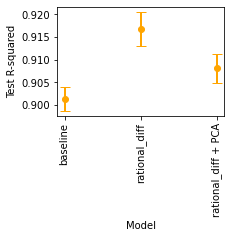

In [112]:
# compare the performance of the existing models.
columns = ['baseline', 'rational_diff', 'rational_diff + PCA']

# select R2 scores with std of the test set
df = NN_scores[columns].loc[(NN_scores.index.get_level_values(0) == 'Test') & (NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Test R-squared')

Following the **inclusion of rational difference features**, the model exhibits **improved performance compared to the baseline model**. However, it's important to note that the **advantage over the baseline model diminishes when dimensionality reduction with PCA is applied**.

### 2C. Additional features ###

In this section, we will assess the **combined impact of all engineered features**, including **polynomial features, rational difference features, and power transformers**.

### _2C.1 All engineered features_ ###

Ultimately, we will create a pipeline that integrates polynomial and rational difference features, along with power transformers. These features were identified during Exploratory Data Analysis and aim to enhance the model's performance.

In [113]:
# transformer applying PolynomialFeatures and PowerTransformer to 13 original features
transformers = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), original_features),
        ('power', PowerTransformer(), original_features)
    ],
    remainder='passthrough'
)

In [114]:
# Create a pipeline with transformers, scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('transformers', transformers),
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=708, epochs=10, batch_size=32, verbose=1))
])

Let's specify a set of parameters to explore when configuring the `create_mlp_model` function and optimize the model.

In [115]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes': [
        [1024], [512], [256], [128], [64],  # Single-layer architectures
        [1024, 512], [512, 256], [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [1024, 512, 256], [512, 256, 128], [256, 128, 64], [128, 64, 32],  # Three-layer architectures
        [1024, 512, 256, 128], [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16],  # Four-layer architectures
        [512, 256, 128, 64, 32], [256, 128, 64, 32, 16]],  # Five-layer architectures
    'nn__model__activation': ['relu','tanh'],
    'nn__model__learning_rate': [0.001, 0.0001],
    'nn__model__optimizer': ['adam', 'sgd']
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_all_features = grid_search.fit(X_train, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_all_features, 'models/NN_all_grid_result.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were evaluated using optimal parameters, including 'tanh' activation, 'adam' optimizer, and the learning rate of 0.0001: **[4096, 2048], [2048, 1024], [4096, 2048, 1024], [2048, 1024, 512], [4096, 2048, 1024, 512], [2048, 1024, 512, 256], [2048, 1024, 512, 256, 128], [1024, 512, 256, 128, 64]**.

In [116]:
# load the GridSearchCV results
grid_all_features = joblib.load('models/NN_all_grid_result.joblib')

Let's examine the **outcomes of the optimization**.

In [117]:
# the best parameters
best_params = grid_all_features.best_params_
best_params

{'nn__model__activation': 'tanh',
 'nn__model__hidden_layer_sizes': [1024, 512, 256, 128],
 'nn__model__learning_rate': 0.0001,
 'nn__model__optimizer': 'adam'}

In [118]:
# summary of the GridSearchCV
results = joblib.load('models/NN_all_grid_results_all.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9166 (0.0029)
Test set R2 score: 0.8876 (0.0046)

Training set MSE score: -0.1295 (0.0045)
Test set MSE score: -0.1743 (0.0055)


To gain a deeper insight into how parameter choices impact the performance of the MLP model, let's **visualize the performance across various combinations of parameters**.

In [119]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

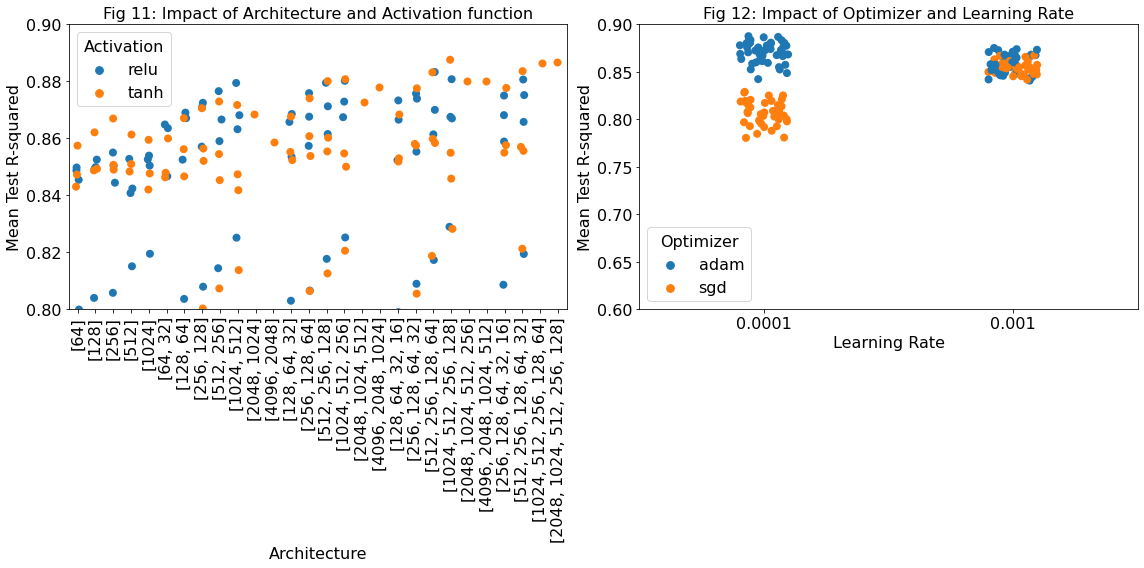

In [120]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 11: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 11: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 
ax1.set_ylim([0.80, 0.90]) 

# fig 12: Impact of Optimizer and Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 12: Impact of Optimizer and Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.set_ylim([0.60, 0.90]) 

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

After analysis of the above figures the selected architecture is **[1024, 512, 256, 128]**

To **assess the model's performance on entirely unseen data**, we will fit the model with the **optimal architecture** for more epochs and employ **early stopping**. We'll use the complete training-validation dataset and make predictions for the target values.

In [121]:
# Create the MLP model using the best parameters
model = create_mlp_model(
    input_dim=708,
    activation=best_params['nn__model__activation'],
    hidden_layer_sizes=best_params['nn__model__hidden_layer_sizes'],
    learning_rate=best_params['nn__model__learning_rate'],
    optimizer=best_params['nn__model__optimizer']
)

In [122]:
# Transform and scale the data
X_train_all_features = pd.DataFrame(pipeline[:-1].fit_transform(X_train))
X_test_all_features = pd.DataFrame(pipeline[:-1].transform(X_test))

In [ ]:
# Fit the MLP model
history_all_features = model.fit(X_train_all_features, y_train, validation_split=0.2, epochs=600, batch_size=32, verbose=0, callbacks=[early_stopping])

In [123]:
# save/load the information about the training process
#joblib.dump(history_all_features, 'models/NN_history_all_features.joblib')
history_all_features = joblib.load('models/NN_history_all_features.joblib')
#joblib.dump(model, 'models/NN_model_all_features.joblib')
model = joblib.load('models/NN_model_all_features.joblib')

Let's visualize the **progression of training and test set loss over epochs** during the training of the MLP model.

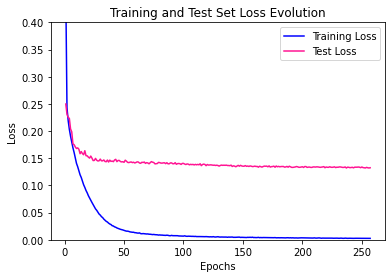

In [124]:
# Extract training and test set loss values from the training history
train_loss = history_all_features.history['loss']
test_loss = history_all_features.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.0, 0.4])
plt.legend()

plt.show()

In [125]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model.predict(X_train_all_features).flatten())
y_test_pred = pd.Series(model.predict(X_test_all_features).flatten())

384/384 [==============================] - 1s 2ms/step


In [126]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train_all_features)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9814)
Test set adjusted R2 score: 0.9087)

Training set MSE score: -0.0284)
Test set MSE score: -0.1373)


Now, let's **integrate the model scores into the summary** dataframe. **We'll assess and compare them once we have the performance of the model with PCA applied**.

In [127]:
add_scores('all_features')

### 2C.2 All engineered features + PCA

The dataset including polynomial features, rational difference features and power transformed features has **already been standardized**, and it encompasses the **following count of features**:

In [128]:
X_train_all_features.shape[1]

708

Let's fit the model and **identify the number of components that contribute to 99% of the explained variance**.

In [129]:
# Initialize PCA with the the number of features
pca = PCA()

# Fit and transform the data
X_train_all_pca = pca.fit_transform(X_train_all_features)

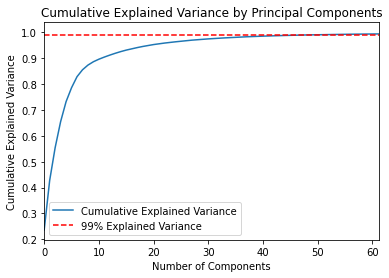

In [130]:
# Compute the explained variance ratio and cumulative explained variance
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = explained_var_ratio.cumsum()

# Find the number of principal components that explain at least 99% of the variance
n_components = np.argmax(cumulative_var_ratio >= 0.99) + 1

# Plot cumulative explained variance
plt.plot(cumulative_var_ratio, label='Cumulative Explained Variance')
plt.axhline(y=0.99, color='red', linestyle='--', label='99% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim([0, 1.2*n_components]) 
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.show()

To capture **99% of the variance**, we **require the following number of components**:

In [131]:
n_components

51

Let's initialize PCA with the number of components determined above and fit the model to **obtain datasets with a reduced number of features**.

In [ ]:
# Initialize PCA with the the number of features
pca = PCA(n_components)

# Fit and transform the data
X_train_all_pca = pd.DataFrame(pca.fit_transform(X_train_all_features))
X_test_all_pca = pd.DataFrame(pca.transform(X_test_all_features))

Now that we have a dataset with a reduced number of components, let's construct a pipeline, define a parameters grid, and optimize the model.

In [135]:
# Create a pipeline with Scaler and KerasRegressor based on the MLP model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasRegressor(model=create_mlp_model, input_dim=X_train_all_pca.shape[1], epochs=10, batch_size=32, verbose=1))
])

In [136]:
# Define hyperparameters to search
param_grid = {
    'nn__model__hidden_layer_sizes':[
        [1024], [512], [256], [128], [64], [32], # Single-layer architectures
        [1024, 512], [512, 256], [256, 128], [128, 64], [64, 32],  # Two-layer architectures
        [2048, 1024, 512], [1024, 512, 256], [512, 256, 128], [256, 128, 64], [128, 64, 32],  # Three-layer architectures
        [2048, 1024, 512, 256], [1024, 512, 256, 128], [512, 256, 128, 64], [256, 128, 64, 32], [128, 64, 32, 16],  # Four-layer architectures
        [2048, 1024, 512, 256, 128], [1024, 512, 256, 128, 64], [512, 256, 128, 64, 32], [256, 128, 64, 32, 16]],  # Fivee-layer architectures
    'nn__model__activation': ['relu', 'tanh'],
    'nn__model__learning_rate': [0.001, 0.0001],
    'nn__model__optimizer': ['adam']
}

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, refit='MSE', return_train_score=True, cv=cv)
grid_all_pca = grid_search.fit(X_train_all_pca, y_train)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_all_pca, 'models/NN_all_pca_grid_results.joblib')

Following the initial analysis of the results, the grid was expanded to include additional architectures. These architectures were determined using optimal parameters, including 'relu' activation, 'adam' optimizer, and a learning rate of 0.0001: **[4096, 2048, 1024], [4096, 2048, 1024, 512], [4096, 2048, 1024, 512, 256]**

In [137]:
# load the GridSearchCV results
grid_all_pca = joblib.load('models/NN_all_pca_grid_results.joblib')

Let's examine the **outcomes of the optimization**.

In [138]:
# the best parameters
best_params = grid_all_pca.best_params_
best_params

{'nn__model__activation': 'relu',
 'nn__model__hidden_layer_sizes': [2048, 1024, 512, 256, 128],
 'nn__model__learning_rate': 0.0001,
 'nn__model__optimizer': 'adam'}

In [139]:
# summary of the GridSearchCV
results = joblib.load('models/NN_all_pca_grid_results_all.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.9356 (0.0019)
Test set R2 score: 0.8964 (0.0033)

Training set MSE score: -0.1000 (0.0032)
Test set MSE score: -0.1607 (0.0030)


To gain a deeper insight into **how parameter choices impact the performance of the MLP model**, let's visualize the performance across various combinations of parameters.

In [140]:
# Sort the architectures by no. of layers and their width
# Add columns required for sorting
results['layers'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: str(x).count(','))
results['nodes'] = results['param_nn__model__hidden_layer_sizes'].apply(lambda x: int(str(x).split('[')[1].split(',')[0].split(']')[0].strip()))
results = results.sort_values(by=['layers', 'nodes'])

# Drop the temporary columns used for sorting
results = results.drop(columns=['layers', 'nodes'])

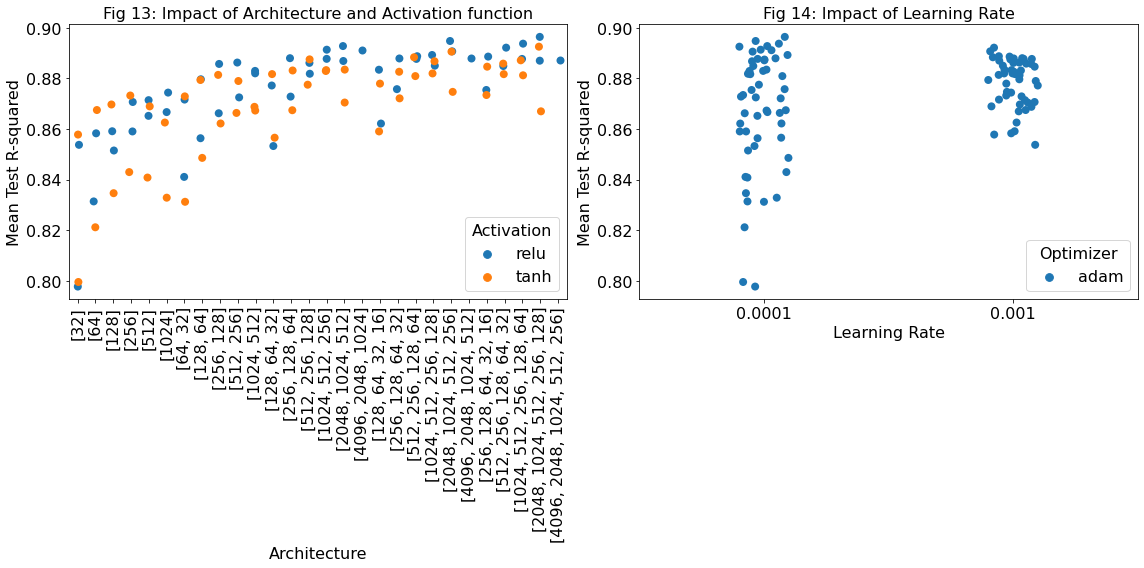

In [141]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# fig 13: Impact of Architecture and Activation function
results['param_nn__model__hidden_layer_sizes'] = results['param_nn__model__hidden_layer_sizes'].astype(str)
sns.stripplot(data=results, x='param_nn__model__hidden_layer_sizes', y='mean_test_R-squared', hue='param_nn__model__activation', ax=ax1, size=8)
ax1.set_title('Fig 13: Impact of Architecture and Activation function', fontsize=16)
ax1.set_xlabel('Architecture', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Activation', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='x', rotation=90) 

# fig 14: Impact of Learning Rate
sns.stripplot(data=results, x='param_nn__model__learning_rate', y='mean_test_R-squared', hue='param_nn__model__optimizer', ax=ax2, size=8)
ax2.set_title('Fig 14: Impact of Learning Rate', fontsize=16)
ax2.set_xlabel('Learning Rate', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Optimizer', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

Once again, the distinctions between architectures with three, four, and five layers are not substantial. The optimal architecture is **[2048, 1024, 512, 256, 128]**.

Now that we have determined the **optimal architecture** and tuned other hyperparameters, it's time to **evaluate the model's performance on entirely unseen data**. We will train the model for additional epochs, employing an early stopping mechanism, and utilizing the complete training-validation dataset. Subsequently, we will make predictions for the target values in the test set.

In [142]:
# MLP model with best parameters
model1 = create_mlp_model(
    input_dim=X_train_all_pca.shape[1],
    activation=best_params['nn__model__activation'],
    hidden_layer_sizes=[2048, 1024, 512, 256, 128],
    learning_rate=best_params['nn__model__learning_rate'],
    optimizer=best_params['nn__model__optimizer']
)

In [143]:
# Scale the input data
X_train_all_pca = pd.DataFrame(pipeline[:-1].fit_transform(X_train_all_pca))
X_test_all_pca = pd.DataFrame(pipeline[:-1].transform(X_test_all_pca))

In [ ]:
# Fit the MLP model
history_all_pca1 = model1.fit(X_train_all_pca, y_train, validation_split=0.2, epochs=600, batch_size=32, verbose=0, callbacks=[early_stopping])

In [144]:
# save/load the information about the training process
#joblib.dump(history_all_pca1, 'models/NN_history_all_pca1.joblib')
history_all_pca1 = joblib.load('models/NN_history_all_pca1.joblib')
#joblib.dump(model1, 'models/NN_model_all_pca1.joblib')
model1 = joblib.load('models/NN_model_all_pca1.joblib')

Let's visualize the **progression of training and test set loss over epochs** during the training of the MLP model.

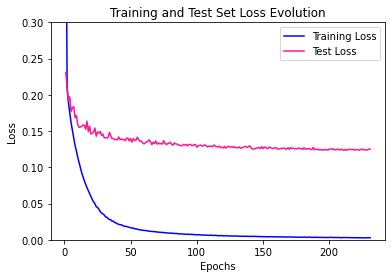

In [145]:
# Extract training and test set loss values from the training history
train_loss = history_all_pca1.history['loss']
test_loss = history_all_pca1.history['val_loss']

# Create a range of values representing the epochs 
epochs = range(1, len(train_loss) + 1)

# Plot Training and Test Set Loss Evolution
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'deeppink', label='Test Loss')
plt.title('Training and Test Set Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.0, 0.3])
plt.legend()

plt.show()

In [146]:
# predict the target values for both the training-validation and test sets
y_train_pred = pd.Series(model1.predict(X_train_all_pca).flatten())
y_test_pred = pd.Series(model1.predict(X_test_all_pca).flatten())

384/384 [==============================] - 2s 5ms/step


The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [147]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.9826)
Test set adjusted R2 score: 0.9196)

Training set MSE score: -0.0270)
Test set MSE score: -0.1267)


Now, let's **incorporate the scores** of the model with PCA-reduced polynomial features into the dataframe and **visualize the results**.

In [148]:
add_scores('all_features + PCA')

In [149]:
NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Test') & NN_scores.index.get_level_values(1).isin(['CV_R2', 'CV_R2_std', 'Adjusted R2'])]

baseline  polynomial  polynomial + PCA  rational_diff  \
Set  Scoring                                                              
Test CV_R2        0.885952    0.887008          0.894873       0.887309   
     CV_R2_std    0.002607    0.005090          0.002762       0.003800   
     Adjusted R2  0.901372    0.912053          0.893718       0.916769   

                  rational_diff + PCA  all_features  all_features + PCA  
Set  Scoring                                                             
Test CV_R2                   0.890176      0.887595            0.896389  
     CV_R2_std               0.003199      0.004640            0.003276  
     Adjusted R2             0.908127      0.908653            0.919573

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

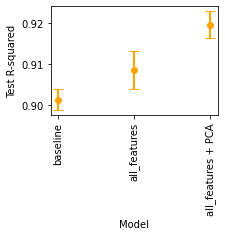

In [150]:
# compare the existing models
columns = ['baseline', 'all_features', 'all_features + PCA']

# select R2 scores with std of the test set
df = NN_scores[columns].loc[(NN_scores.index.get_level_values(0) == 'Test') & (NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xlabel('Model')
plt.ylabel('Test R-squared')
plt.xticks(rotation = 90)

Above, it's evident that there is a **statistically significant difference in performance** between the baseline model and the model **after incorporating polynomial, rational difference and power transformed features**. Additionally, **dimensionality reduction** with PCA has notably **enhanced the model's performance**.

Now, let's **evaluate the model's quality visually**.

Visual representation of the model's fit to the **training-validation set**.

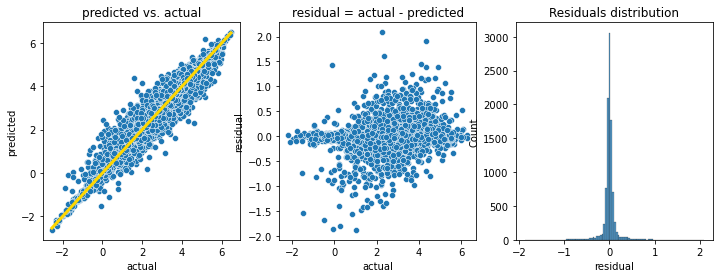

In [151]:
pm.visualize_fit(y_train, y_train_pred)

Visual representation of the model's fit to the **unseen test set**.

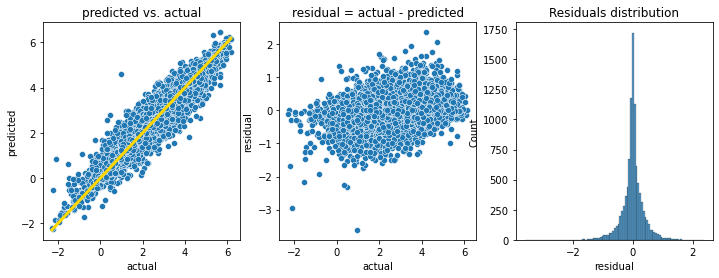

In [152]:
pm.visualize_fit(y_test, y_test_pred)

The model exhibits a strong fit to the training set and consistently performs well on the test set. Notably, the **residual versus actual value plots** for both training and test sets **reveal only minimal patterns**, representing **some improvement compared to the baseline model**.

## 3. Summary

### 3.A. An Approach to Addressing Uncertainties

The comparison between the regular R-squared (R²) and the adjusted R-squared (adjusted R²) reveals a **slightly higher**, but still **comparable**, value for the **adjusted R²**. Adjusted R² calculates a correction based on both the **number of features and the number of samples**, which makes the **results more comparable** between models containing different numbers of features.


The scores' **uncertainty is assessed exclusively during GridSearchCV**. Nevertheless, we assume that the **uncertainties associated with the values acquired for the unseen test data are of a comparable order of magnitude, and we will utilize them for the plots**.

On one hand, the metric's value for the unseen data is less accurate because it's a single value, in contrast to an average of 10 measurements as in GridSearchCV. On the other hand, the model used to obtain the target values for the unseen test data was trained on a slightly larger dataset. Additionally, the unseen test set itself is approximately twice as large as the test sets used in GridSearchCV.

### 3.B Influence of engineered features and dimentionality reduction

Let's evaluate the model's evolution by analyzing the Adjusted R2 values at critical stages, encompassing feature engineering and dimensionality reduction. Adjusted R2 enables comparison across models with different feature counts. 

In [153]:
# select Adjusted R2 values together with std values
metrics_test = NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Test')&(NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_test['Set'] = 'Test'
metrics_train = NN_scores.loc[(NN_scores.index.get_level_values(0) == 'Train')&(NN_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_train['Set'] = 'Train'
metrics = pd.concat([metrics_train, metrics_test])

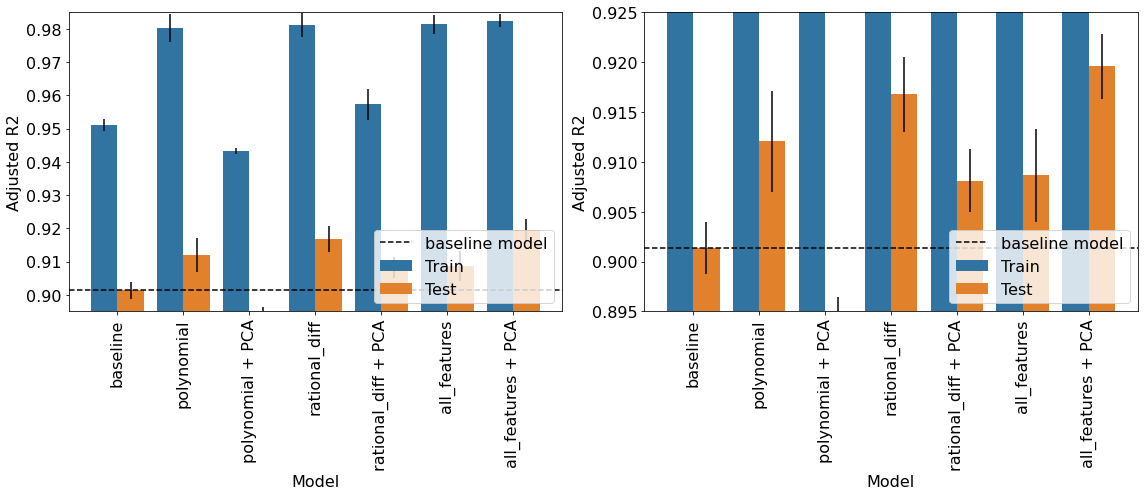

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# set the figure size
plt.figure(figsize=(16, 7))

# create the first bar plot with adjusted y-axis limits
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=metrics, x=metrics.index, y='Adjusted R2', hue='Set')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=metrics['CV_R2_std'], fmt="none", c="k")
ax1.axhline(y=metrics.loc['baseline', 'Adjusted R2'].values[1], color='black', linestyle='--', label='baseline model')
plt.xlabel('Model', fontsize=16)  
plt.ylabel('Adjusted R2', fontsize=16) 
plt.ylim(0.895, 0.985)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# create the second bar plot with different y-axis limits
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=metrics, x=metrics.index, y='Adjusted R2', hue='Set')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=metrics['CV_R2_std'], fmt="none", c="k")
ax2.axhline(y=metrics.loc['baseline', 'Adjusted R2'].values[1], color='black', linestyle='--', label='baseline model')
plt.xlabel('Model', fontsize=16)  
plt.ylabel('Adjusted R2', fontsize=16) 
plt.ylim(0.895, 0.925)  # Adjust the y-axis limits as needed
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

* On the left-hand side plot, we observe that all models demonstrate good performance on the **training data**. However, the **introduction of additional features significantly enhances their overall performance**.


* On the right-hand plot, the incorporation of extra features markedly improves the model's performance on the **test data**. **Rational difference features exhibit a slightly more positive influence compared to polynomial features**. Notably, the model incorporating **all feature types** (polynomial, rational difference, and power-transformed) **achieves the highest scores**.


* The **application of PCA**, optimized to explain 99% of the original variance, results in performance **improvements for models with added polynomial and all types of features**. For the model with rational difference features, achieving 99% explained variance with only 13 components (equivalent to the number of original features) leads to the lowest performance among the enhanced models.

In [155]:
# save Linear Regression's metrics for further comparison
NN_scores.to_csv('NN_scores.csv', index=False)